In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


file_path = "adult.csv"
df = pd.read_csv(file_path)

df.replace("?", np.nan, inplace=True)
print(df.isnull().sum())

categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,8,77053,11,9,6,14,1,4,0,0,4356,40,38,0
1,82,3,132870,11,9,6,3,1,4,0,0,4356,18,38,0
2,66,8,186061,15,10,6,14,4,2,0,0,4356,40,38,0
3,54,3,140359,5,4,0,6,4,4,0,0,3900,40,38,0
4,41,3,264663,15,10,5,9,3,4,0,0,3900,40,38,0


Basic EDA, cleaning of data, removing of null values etc. 

In [4]:
print("Correlation with income:")
print(df[['capital.gain', 'capital.loss', 'income']].corr())
print(f"Capital Gain - % of zeros: {100 * (df['capital.gain'] == 0).sum() / len(df):.2f}%")
print(f"Capital Loss - % of zeros: {100 * (df['capital.loss'] == 0).sum() / len(df):.2f}%")


Correlation with income:
              capital.gain  capital.loss    income
capital.gain      1.000000     -0.031615  0.223329
capital.loss     -0.031615      1.000000  0.150526
income            0.223329      0.150526  1.000000
Capital Gain - % of zeros: 91.67%
Capital Loss - % of zeros: 95.33%


Since the number of Zero values are more than 90% we can end up removing the columns. Moreover, correlation value is close to 0 for both the columns. Hence it's a safe assumption that these columns end up contributing to the noise more than the actual model. 

In [ ]:
df.drop(columns=['capital.gain', 'capital.loss'], inplace=True)


In [7]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,income
0,90,8,77053,11,9,6,14,1,4,0,40,38,0
1,82,3,132870,11,9,6,3,1,4,0,18,38,0
2,66,8,186061,15,10,6,14,4,2,0,40,38,0
3,54,3,140359,5,4,0,6,4,4,0,40,38,0
4,41,3,264663,15,10,5,9,3,4,0,40,38,0


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X = df.drop(columns=['income'])  
y = df['income']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)

y_pred_gini = dt_gini.predict(X_test)
accuracy_gini = accuracy_score(y_test, y_pred_gini)

print(f"Accuracy (Gini Index): {accuracy_gini}")


Accuracy (Gini Index): 0.7745977152683945


In [12]:
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)

y_pred_entropy = dt_entropy.predict(X_test)
accuracy_entropy = accuracy_score(y_test, y_pred_entropy)

print(f"Accuracy (Entropy): {accuracy_entropy}")


Accuracy (Entropy): 0.7801252917332023


In [13]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance (Gini)': dt_gini.feature_importances_,
    'Importance (Entropy)': dt_entropy.feature_importances_
}).sort_values(by='Importance (Gini)', ascending=False)

print(feature_importances)


           Feature  Importance (Gini)  Importance (Entropy)
2           fnlwgt           0.251812              0.246549
7     relationship           0.208855              0.201787
0              age           0.139434              0.156574
4    education.num           0.135071              0.120151
10  hours.per.week           0.078104              0.086549
6       occupation           0.072934              0.078965
1        workclass           0.050766              0.041216
11  native.country           0.020217              0.018900
8             race           0.016482              0.015357
3        education           0.013312              0.014793
5   marital.status           0.007562              0.012715
9              sex           0.005450              0.006445


In [14]:
from sklearn.metrics import classification_report

print("Classification Report (Gini Index):")
print(classification_report(y_test, y_pred_gini))

print("Classification Report (Entropy):")
print(classification_report(y_test, y_pred_entropy))


Classification Report (Gini Index):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      6197
           1       0.53      0.54      0.53      1944

    accuracy                           0.77      8141
   macro avg       0.69      0.69      0.69      8141
weighted avg       0.78      0.77      0.78      8141

Classification Report (Entropy):
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6197
           1       0.54      0.55      0.54      1944

    accuracy                           0.78      8141
   macro avg       0.70      0.70      0.70      8141
weighted avg       0.78      0.78      0.78      8141



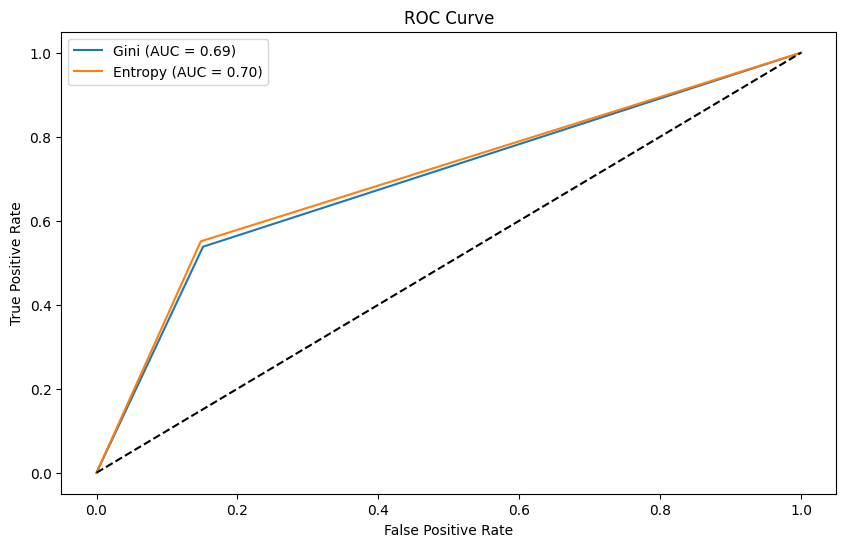

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_gini = dt_gini.predict_proba(X_test)[:, 1]
y_prob_entropy = dt_entropy.predict_proba(X_test)[:, 1]

roc_auc_gini = roc_auc_score(y_test, y_prob_gini)
roc_auc_entropy = roc_auc_score(y_test, y_prob_entropy)

fpr_gini, tpr_gini, _ = roc_curve(y_test, y_prob_gini)
fpr_entropy, tpr_entropy, _ = roc_curve(y_test, y_prob_entropy)

plt.figure(figsize=(10, 6))
plt.plot(fpr_gini, tpr_gini, label=f'Gini (AUC = {roc_auc_gini:.2f})')
plt.plot(fpr_entropy, tpr_entropy, label=f'Entropy (AUC = {roc_auc_entropy:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [16]:
print(f"Accuracy (Gini Index): {accuracy_gini}")
print(f"Accuracy (Entropy): {accuracy_entropy}")
print(f"AUC (Gini Index): {roc_auc_gini}")
print(f"AUC (Entropy): {roc_auc_entropy}")


Accuracy (Gini Index): 0.7745977152683945
Accuracy (Entropy): 0.7801252917332023
AUC (Gini Index): 0.693431824505552
AUC (Entropy): 0.7014755496984801


Decision Tree (Gini Index):
|--- relationship <= 0.50
|   |--- education.num <= 12.50
|   |   |--- education.num <= 7.50
|   |   |   |--- age <= 35.50
|   |   |   |   |--- fnlwgt <= 29417.50
|   |   |   |   |   |--- fnlwgt <= 28259.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- fnlwgt >  28259.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- fnlwgt >  29417.50
|   |   |   |   |   |--- occupation <= 1.00
|   |   |   |   |   |   |--- fnlwgt <= 204282.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- fnlwgt >  204282.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- occupation >  1.00
|   |   |   |   |   |   |--- workclass <= 4.50
|   |   |   |   |   |   |   |--- native.country <= 40.00
|   |   |   |   |   |   |   |   |--- hours.per.week <= 67.50
|   |   |   |   |   |   |   |   |   |--- education.num <= 6.50
|   |   |   |   |   |   |   |   |   |   |--- fnlwgt <= 181303.50
|   |   |   |   |   |   |   |   |   |   | 

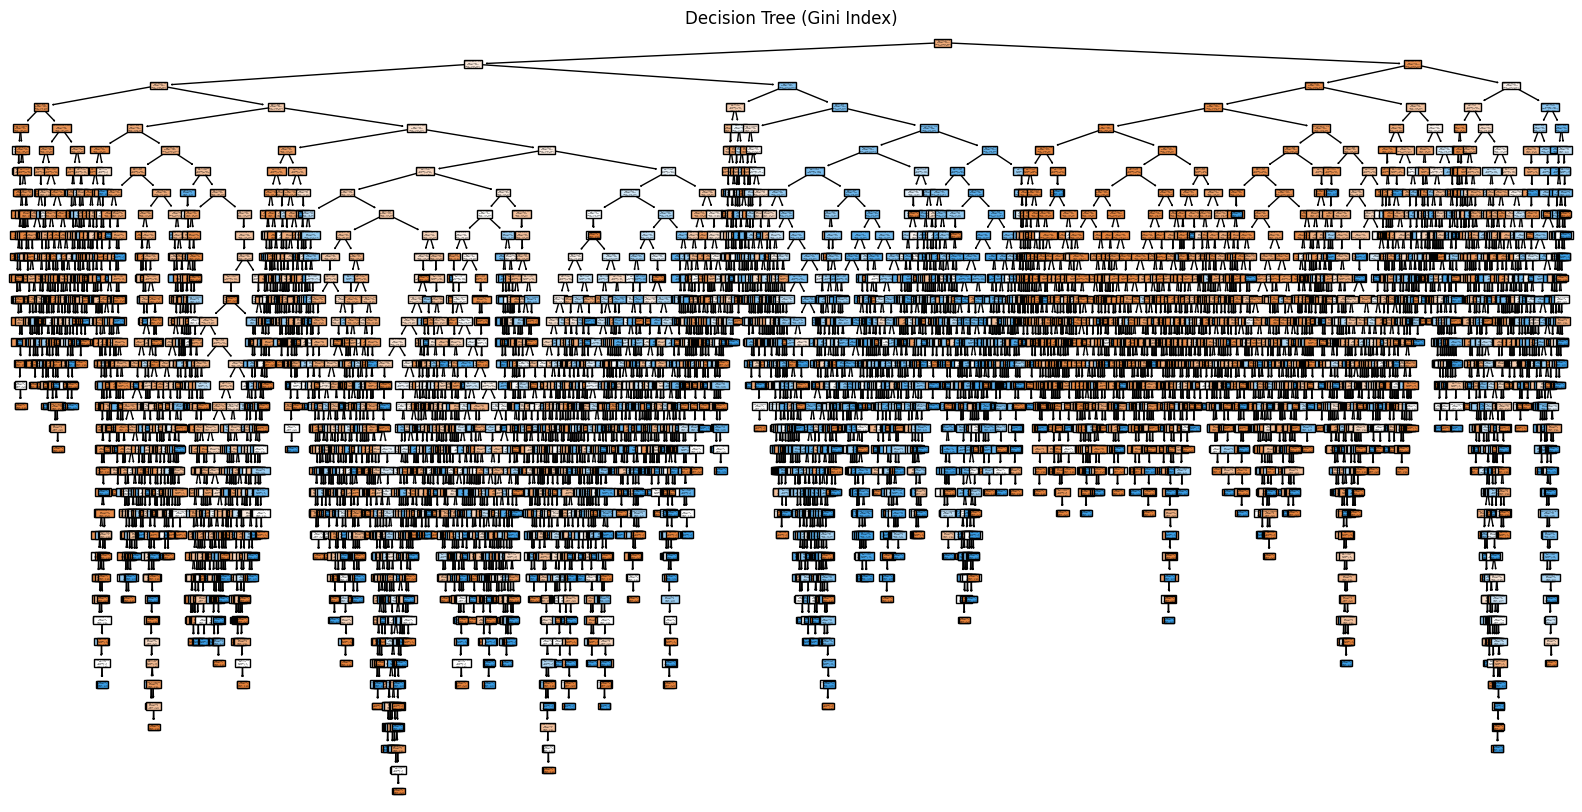

In [19]:
from sklearn.tree import export_text, plot_tree

print("Decision Tree (Gini Index):")
print(export_text(dt_gini, feature_names=list(X.columns)))

plt.figure(figsize=(20, 10))
plot_tree(dt_gini, feature_names=X.columns, class_names=['<=50K', '>50K'], filled=True)
plt.title("Decision Tree (Gini Index)")
plt.show()


Decision Tree (Entropy):
|--- relationship <= 0.50
|   |--- education.num <= 12.50
|   |   |--- education.num <= 7.50
|   |   |   |--- age <= 35.50
|   |   |   |   |--- native.country <= 29.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- native.country >  29.50
|   |   |   |   |   |--- native.country <= 30.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- native.country >  30.50
|   |   |   |   |   |   |--- education <= 5.50
|   |   |   |   |   |   |   |--- workclass <= 4.50
|   |   |   |   |   |   |   |   |--- hours.per.week <= 67.50
|   |   |   |   |   |   |   |   |   |--- fnlwgt <= 249018.00
|   |   |   |   |   |   |   |   |   |   |--- fnlwgt <= 247184.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- fnlwgt >  247184.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- fnlwgt >  249018.00
|   |   |   |   |   |   |   |   |   |   |--- c

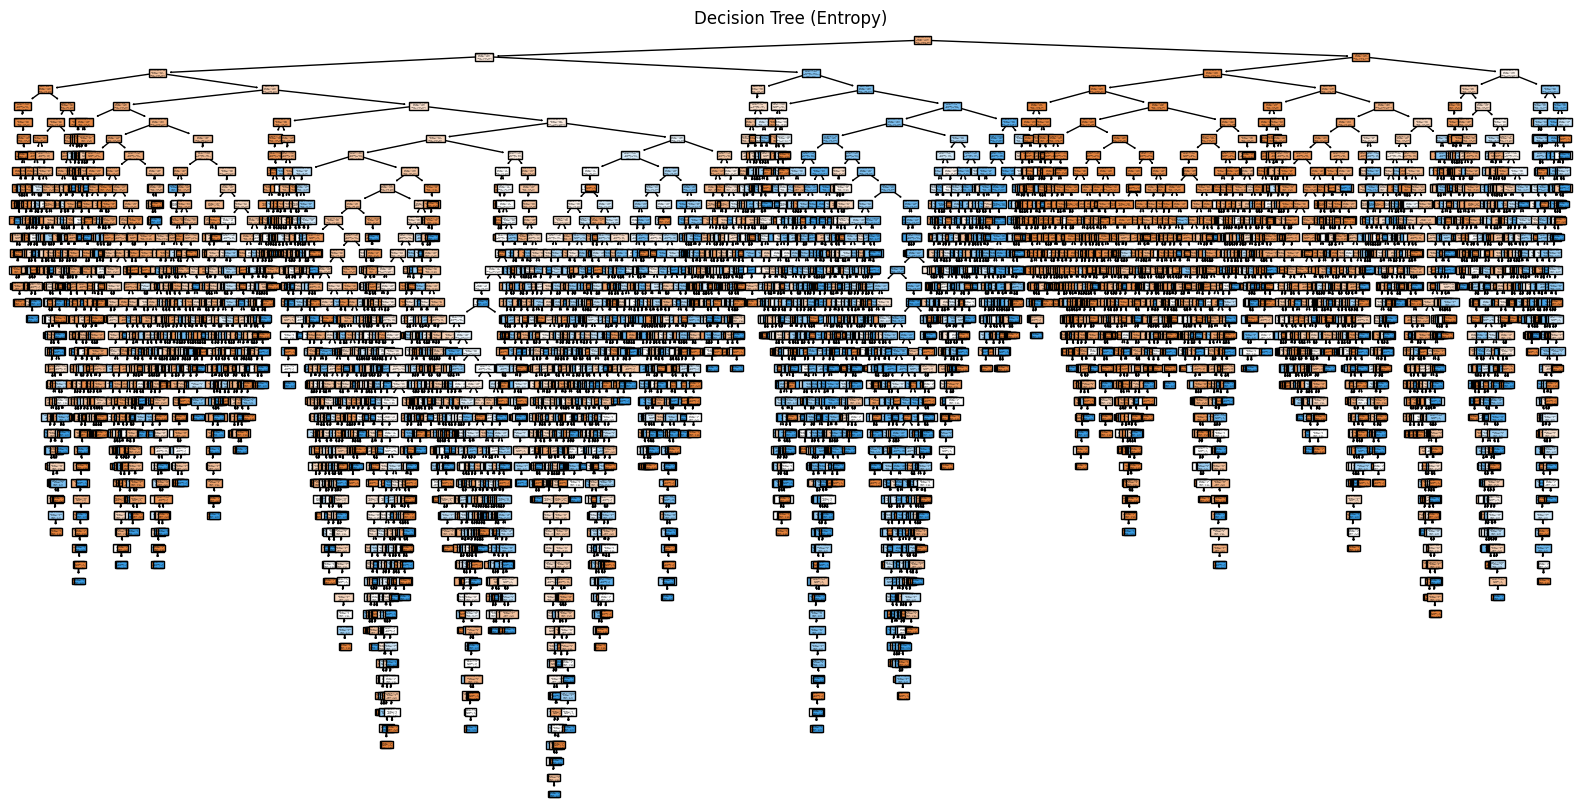

In [20]:
print("Decision Tree (Entropy):")
print(export_text(dt_entropy, feature_names=list(X.columns)))

plt.figure(figsize=(20, 10))
plot_tree(dt_entropy, feature_names=X.columns, class_names=['<=50K', '>50K'], filled=True)
plt.title("Decision Tree (Entropy)")
plt.show()


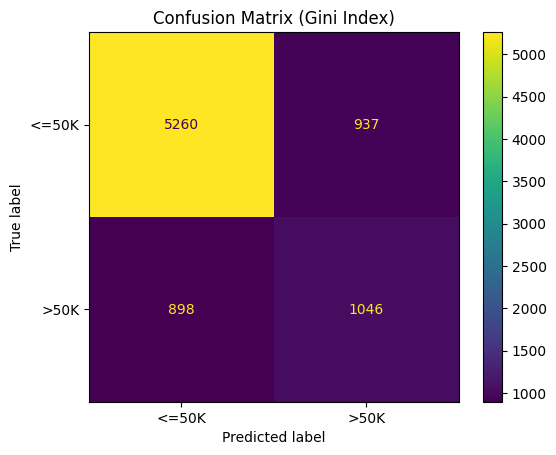

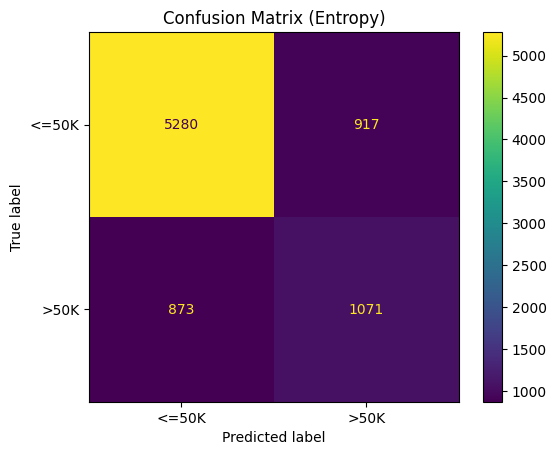

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_gini = confusion_matrix(y_test, y_pred_gini)
disp_gini = ConfusionMatrixDisplay(confusion_matrix=cm_gini, display_labels=['<=50K', '>50K'])
disp_gini.plot()
plt.title("Confusion Matrix (Gini Index)")
plt.show()

cm_entropy = confusion_matrix(y_test, y_pred_entropy)
disp_entropy = ConfusionMatrixDisplay(confusion_matrix=cm_entropy, display_labels=['<=50K', '>50K'])
disp_entropy.plot()
plt.title("Confusion Matrix (Entropy)")
plt.show()


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)

k = 10

scores_gini = cross_val_score(clf_gini, X, y, cv=k, scoring='accuracy')
print(f"Gini Index Cross-Validation Scores: {scores_gini}")
print(f"Gini Index Mean Accuracy: {scores_gini.mean():.4f}")
print(f"Gini Index Standard Deviation: {scores_gini.std():.4f}")

scores_entropy = cross_val_score(clf_entropy, X, y, cv=k, scoring='accuracy')
print(f"Entropy Cross-Validation Scores: {scores_entropy}")
print(f"Entropy Mean Accuracy: {scores_entropy.mean():.4f}")
print(f"Entropy Standard Deviation: {scores_entropy.std():.4f}")


Gini Index Cross-Validation Scores: [0.76512128 0.77948403 0.7730344  0.76658477 0.7742629  0.7791769
 0.78654791 0.77395577 0.78009828 0.77395577]
Gini Index Mean Accuracy: 0.7752
Gini Index Standard Deviation: 0.0061
Entropy Cross-Validation Scores: [0.76266503 0.78869779 0.7767199  0.76658477 0.78316953 0.76719902
 0.79453317 0.7767199  0.77395577 0.77272727]
Entropy Mean Accuracy: 0.7763
Entropy Standard Deviation: 0.0096



Both Decision Tree models (Gini Index and Entropy) show similar performance, with the Entropy model slightly outperforming the Gini model in accuracy (78.01% vs. 77.46%). The AUC values are also close, with Entropy at 0.701 and Gini at 0.693, indicating both models are fairly good at distinguishing between classes. However, there's room for improvement, particularly in capturing the minority class more effectively.